In [3]:
## Figure 2 - plot comparison of different unwrapping error correction methods
import os
from matplotlib import pyplot as plt, ticker
from pysar.objects import sensor
from pysar.utils import readfile, plot as pp
from pysar.simulation.plot import *
from pysar.unwrap_error_bridging import water_mask2conn_comp_mask, search_bridge, plot_bridge

work_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR/UNW_COR')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
proj_name = sensor.project_name2sensor_name(work_dir)[1]

ifgram_file = '../INPUTS/ifgramStack.h5'
water_mask_file = '../waterMask.h5'
coh_mask_file = '../maskSpatialCoh.h5'
mask_cc_file = '../maskConnComp.h5'
atr = readfile.read_attribute(ifgram_file)
ref_y, ref_x = int(atr['REF_Y']), int(atr['REF_X'])

tcoh_files= ['tempCoh_unwrapPhase.h5',
             'tempCoh_unwrapPhase_bridge.h5',
             'tempCoh_unwrapPhase_bridge_closure.h5']
## Points of Interest
pts_yx = []
pts_yx.append([930, 1250])
pts_yx.append([620, 140])

Go to directory: /Users/yunjunz/insarlab/Galapagos/GalapagosSenDT128/PYSAR/UNW_COR


In [2]:
## run unwrap_error_*.py
cmd  = 'unwrap_error_bridging.py {} --water-mask {} '.format(ifgram_file, water_mask_file)
cmd += ' --update -i unwrapPhase -o unwrapPhase_bridge\n'
cmd += 'unwrap_error_phase_closure.py {} --update --fast '.format(ifgram_file)
cmd += ' -i unwrapPhase_bridge -o unwrapPhase_bridge_closure'
print(cmd)
#os.system(cmd)

unwrap_error_bridging.py ../INPUTS/ifgramStack.h5 --water-mask ../waterMask.h5  --update -i unwrapPhase -o unwrapPhase_bridge
unwrap_error_phase_closure.py ../INPUTS/ifgramStack.h5 --update --fast  -i unwrapPhase_bridge -o unwrapPhase_bridge_closure


In [3]:
## Generate different temporal coherence
for dsName in ['unwrapPhase', 'unwrapPhase_bridge', 'unwrapPhase_bridge_closure']:
    cmd  = 'ifgram_inversion.py {} -w var --water-mask {} '.format(ifgram_file, water_mask_file)
    cmd += '-i {d} -o timeseries.h5 tempCoh_{d}.h5'.format(d=dsName)
    print(cmd)
    #os.system(cmd)

ifgram_inversion.py ../INPUTS/ifgramStack.h5 -w var --water-mask ../waterMask.h5 -i unwrapPhase -o timeseries.h5 tempCoh_unwrapPhase.h5
ifgram_inversion.py ../INPUTS/ifgramStack.h5 -w var --water-mask ../waterMask.h5 -i unwrapPhase_bridge -o timeseries.h5 tempCoh_unwrapPhase_bridge.h5
ifgram_inversion.py ../INPUTS/ifgramStack.h5 -w var --water-mask ../waterMask.h5 -i unwrapPhase_bridge_closure -o timeseries.h5 tempCoh_unwrapPhase_bridge_closure.h5


In [4]:
## search bridges
bridges = search_bridge(mask_cc_file, coh_mask_file=coh_mask_file, save_plot=False)
print('Done.')

--------------------------------------------------
searching bridges to connect coherence conn comps ...
number of bridges: 2
1. calculating min distance between each pair of coherent conn comps ...
conn comp pair: 1 [1164  751] to 2 [1201  803] with distance of 63.8200595424354
conn comp pair: 1 [345 857] to 3 [182 669] with distance of 248.82323042674292
conn comp pair: 2 [1110  907] to 3 [266 589] with distance of 901.9201738513226
2. find MST bridges and determine the briding order using breadth-first ordering
3. find circular area around bridge point with radius of 150 pixels
  with background mask from: ../maskSpatialCoh.h5
save bridge points  to file: maskConnCompBridge.txt
Done.


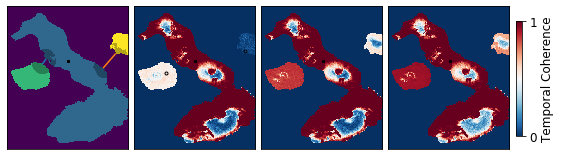

In [15]:
## Figure 2 - Plot mask and temporal coherence
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[9, 4], sharex=True, sharey=True)
axs[0], im0 = plot_bridge(axs[0], mask_cc_file, bridges)
for i in range(len(tcoh_files)):
    ax = axs[i+1]
    data = readfile.read(tcoh_files[i])[0]
    im1 = ax.imshow(data, vmin=0, vmax=1, cmap='RdBu_r')
    ax = pp.auto_flip_direction(atr, ax=ax, print_msg=False)
for ax in axs:
    ax.tick_params(which='both', direction='in', top=True, bottom=True, left=True, right=True, labelsize=font_size)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
fig.subplots_adjust(wspace=0.05)

## reference pixel
for ax in axs:
    ax.plot(ref_x, ref_y, 'ks', ms='2')

## Points of Interest
for yx in pts_yx:
    axs[1].plot(yx[1], yx[0], 'o', ms='3', mfc='none', mec='k')

## colorbar
cax = fig.add_axes([0.91, 0.3, 0.01, 0.4])
cbar = plt.colorbar(im1, cax=cax)
cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=1)
cbar.update_ticks()
cbar.set_label('Temporal Coherence', fontsize=font_size)

plt.savefig('{}_unw_err.png'.format(proj_name), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [12]:
## Detailed Value of Temporal Coherence value on POIs
tcoh_list = []
for fname in tcoh_files:
    tcoh = readfile.read(fname)[0]
    tcoh_list.append(tcoh)

for yx in pts_yx:
    print('Point Y/X: {}'.format(yx))
    for tcoh in tcoh_list:
        print(tcoh[yx[0], yx[1]])

Point Y/X: [930, 1250]
0.4925048
0.85846174
0.9331423
Point Y/X: [620, 140]
0.06883445
0.56652766
0.71353865
